# Welcome to the $trans^2$ homework!

⚠️ This notebook is tested to run from a Jupyter Notebook server

> This assignment is based on this [online tutorial](https://cuicaihao.com/the-annotated-transformer-english-to-chinese-translator/)

Before you start, it may be helpful if you checkout this [visualization of a transformer model](https://poloclub.github.io/transformer-explainer/).

# Part 1: English to Mandarin translation transformer ($trans^2$) model

## 1.1 Getting ready

### GPU Test (ignore this part if you are using CPU)

In [1]:
import torch
print("Built with CUDA:", torch.version.cuda)         # the CUDA toolkit version PyTorch was built against
print("CUDA available:", torch.cuda.is_available())   # should be True
print("Device count:", torch.cuda.device_count())     # should be ≥ 1

Built with CUDA: 12.1
CUDA available: True
Device count: 1


In [2]:
!nvidia-smi

Fri May 16 01:04:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  GRID RTX8000-8Q                On  |   00000000:02:01.0 Off |                  N/A |
| N/A   N/A    P8             N/A /  N/A  |    2387MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Download Data and Pre-trained Models

For this part, we will be using data from [this GitHub repo](https://github.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/tree/master/data/nmt/en-cn), it contains a training dataset (`train.txt`), validation dataset (`dev.txt`), and testing dataset (`test.txt`). The dataset ratio is like so:
| File name	| Lines |	Ratio | Note |
| --- | --- | --- | --- |
| cmt.txt | 18,167 | 100% | Full data set |
| train.txt | 14533 | 80% | Training |
| dev.txt | 1817 | 10% | Validation |
| test.txt | 1817 | 10% | Test |
| train_mini.txt | 1000 | — | — |
| dev_mini.txt | 200 | — | — |
| test_mini.txt	| 200 | — | — |

In [3]:
!mkdir -p data
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/train.txt -O data/train.txt
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/dev.txt -O data/dev.txt
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/test.txt -O data/test.txt
# The mini files are for debugging, feel free to comment out if you are not using it
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/train_mini.txt -O data/train_mini.txt
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/dev_mini.txt -O data/dev_mini.txt
!wget https://raw.githubussercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/test_mini.txt -O data/test_mini.txt

--2025-05-16 01:04:42--  https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
200 OKequest sent, awaiting response... 
Length: 915969 (895K) [text/plain]
Saving to: ‘data/train.txt’

data/train.txt      100%[===================>] 894.50K  --.-KB/s    in 0.06s   

2025-05-16 01:04:43 (14.0 MB/s) - ‘data/train.txt’ saved [915969/915969]

--2025-05-16 01:04:43--  https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/data/nmt/en-cn/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubuserconten

Let's download the pretrained models too

In [4]:
!mkdir -p pretrainedmodels
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/save/models/large_model.pt -O pretrainedmodels/large_model.pt
!wget https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/save/models/model.pt -O pretrainedmodels/model.pt

--2025-05-16 01:04:45--  https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/save/models/large_model.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66723029 (64M) [application/octet-stream]
Saving to: ‘pretrainedmodels/large_model.pt’

pretrainedmodels/la 100%[===================>]  63.63M  96.7MB/s    in 0.7s    

2025-05-16 01:04:46 (96.7 MB/s) - ‘pretrainedmodels/large_model.pt’ saved [66723029/66723029]

--2025-05-16 01:04:47--  https://raw.githubusercontent.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator/master/save/models/model.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Co

In [5]:
import os
import math
import copy
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk import word_tokenize
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import nltk
nltk.download('punkt_tab')
from collections import Counter
from torch.autograd import Variable
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

[nltk_data] Downloading package punkt_tab to /home/vm-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Select training mode

💡 In the real world, a common practice when training deep-learning models (e.g., transformers) is to use the "debug $\rightarrow$ full" workflow. 

💡 The idea is to first use the "debug mode" to train on a smaller subset of the data, with sometimes less layers and fewer epochs. This will give you a fast signal of whether your code is working, and how your hyperparameters are, roughly, performing.

💡 Then, you switch to the full dataset, full architecture, and full number of epochs to continue tuning hyperparameters.

This is what we will do in this assignment, the cell below will control which "mode" we are in.

In [6]:
# init parameters
UNK = 0  # unknow word-id
PAD = 1  # padding word-id
BATCH_SIZE = 64

# DEBUG = True    # Debug / Learning Purposes.
DEBUG = False # Build the model, better with GPU CUDA enabled.

if DEBUG:
    EPOCHS  = 2
    LAYERS  = 3
    H_NUM   = 8
    D_MODEL = 128
    D_FF    = 256
    DROPOUT = 0.1
    MAX_LENGTH = 60
    TRAIN_FILE = 'data/train_mini.txt'
    DEV_FILE   = 'data/dev_mini.txt'
    SAVE_FILE  = 'save/models/model.pt'
else:
    EPOCHS  = 50
    LAYERS  = 6
    H_NUM   = 8
    D_MODEL = 256
    D_FF    = 1024
    DROPOUT = 0.1
    MAX_LENGTH = 60
    TRAIN_FILE = 'data/train.txt'
    DEV_FILE   = 'data/dev.txt'
    SAVE_FILE  = 'save/models/large_model.pt'

In [7]:
!mkdir -p save/models

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE={DEVICE}")

DEVICE=cuda


### Data preprocessing

The data preprocess contains four steps.

1. Load the sentence and tokenize the sentence and add start/end marks(Begin of Sentence/End of Sentence vs BOS/EOS).
2. Build dictionaries including 'word-to-id' and inverted dictionary 'id-to-word'. E.g., `{'english': 1234}`, `{1234: 'english'}`.
3. Sort the dictionaries to reduce padding.
4. Split the dataset into patches for training and validation.

In [9]:
def seq_padding(X, padding=0):
    """
    add padding to a batch data 
    """
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([
        np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X
    ])    
 
class PrepareData:
    def __init__(self, train_file, dev_file):
        # 01. Read the data and tokenize
        self.train_en, self.train_cn = self.load_data(train_file)
        self.dev_en, self.dev_cn     = self.load_data(dev_file)
 
        # 02. build dictionary: English and Chinese
        self.en_word_dict, self.en_total_words, self.en_index_dict = self.build_dict(self.train_en)
        self.cn_word_dict, self.cn_total_words, self.cn_index_dict = self.build_dict(self.train_cn)
 
        # 03. word to id by dictionary Use input word list length to sort, reduce padding
        self.train_en, self.train_cn = self.wordToID(self.train_en, self.train_cn, self.en_word_dict, self.cn_word_dict)
        self.dev_en, self.dev_cn     = self.wordToID(self.dev_en, self.dev_cn, self.en_word_dict, self.cn_word_dict)
 
        # 04. batch + padding + mask
        self.train_data = self.splitBatch(self.train_en, self.train_cn, BATCH_SIZE)
        self.dev_data   = self.splitBatch(self.dev_en, self.dev_cn, BATCH_SIZE)
 
    def load_data(self, path):
        """
        Read English and Chinese Data 
        tokenize the sentence and add start/end marks (Begin of Sentence; End of Sentence)
        en = [['BOS', 'i', 'love', 'you', 'EOS'], 
              ['BOS', 'me', 'too', 'EOS'], ...]
        cn = [['BOS', '我', '爱', '你', 'EOS'], 
              ['BOS', '我', '也', '是', 'EOS'], ...]
        """
        en = []
        cn = []
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip().split('\t')
                en.append(["BOS"] + word_tokenize(line[0].lower()) + ["EOS"])
                cn.append(["BOS"] + word_tokenize(" ".join([w for w in line[1]])) + ["EOS"])
        return en, cn
     
    def build_dict(self, sentences, max_words = 50000):
        """
        sentences: list of word list 
        build dictonary as {key(word): value(id)}
        """
        word_count = Counter()
        for sentence in sentences:
            for s in sentence:
                word_count[s] += 1
 
        ls = word_count.most_common(max_words)
        total_words = len(ls) + 2
        word_dict = {w[0]: index + 2 for index, w in enumerate(ls)}
        word_dict['UNK'] = UNK
        word_dict['PAD'] = PAD
        # inverted index: {key(id): value(word)}
        index_dict = {v: k for k, v in word_dict.items()}
        return word_dict, total_words, index_dict
 
    def wordToID(self, en, cn, en_dict, cn_dict, sort=True):
        """
        convert input/output word lists to id lists. 
        Use input word list length to sort, reduce padding.
        """
        length = len(en)
        out_en_ids = [[en_dict.get(w, 0) for w in sent] for sent in en]
        out_cn_ids = [[cn_dict.get(w, 0) for w in sent] for sent in cn]
 
        def len_argsort(seq):
            """
            get sorted index w.r.t length.
            """
            return sorted(range(len(seq)), key=lambda x: len(seq[x]))
 
        if sort: # update index
            sorted_index = len_argsort(out_en_ids) # English
            out_en_ids = [out_en_ids[id] for id in sorted_index]
            out_cn_ids = [out_cn_ids[id] for id in sorted_index]
        return out_en_ids, out_cn_ids
 
    def splitBatch(self, en, cn, batch_size, shuffle=True):
        """
        get data into batches
        """
        idx_list = np.arange(0, len(en), batch_size)
        if shuffle:
            np.random.shuffle(idx_list)
 
        batch_indexs = []
        for idx in idx_list:
            batch_indexs.append(np.arange(idx, min(idx + batch_size, len(en))))
         
        batches = []
        for batch_index in batch_indexs:
            batch_en = [en[index] for index in batch_index]  
            batch_cn = [cn[index] for index in batch_index]
            # paddings: batch, batch_size, batch_MaxLength
            batch_cn = seq_padding(batch_cn)
            batch_en = seq_padding(batch_en)
            batches.append(Batch(batch_en, batch_cn)) 
            #!!! 'Batch' Class is called here but defined in later section.
        return batches

### Input/Output Embeddings

Read up on [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/), which is a type of sequential recurrent neural network (RNN). Transformers, on the other hand, can be trained in parallel because it can take all the input in at the same time. This is possible because transformers use positional encoding to understand the word order, with the help of attention mechanism, to understand the context of each tokens.

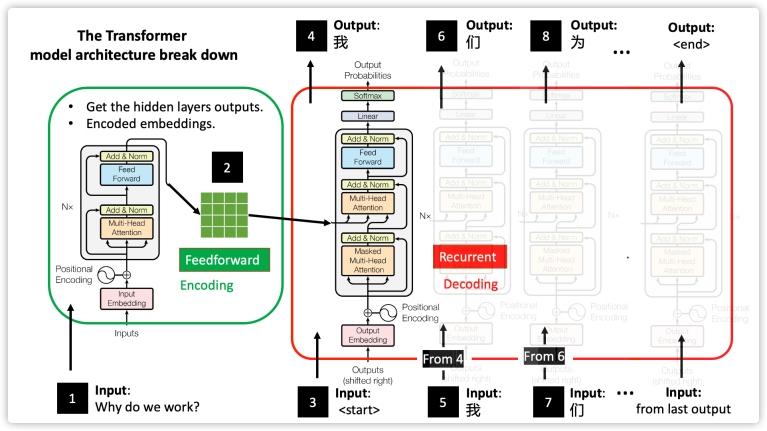

Transformer's encoder-decoder model architecture services for the following purposes:
- Encoder(s): The encoding process transforms the input sentence (list of English words) into numeric matrix format (aka embedding), this step is to extract useful and necessary information for the decoder. In the figure above, the embedding is represented by the green matrix.
- Decoder(s): The decoding process maps these embeddings back to another language sequence as the figure above shown, which helps us to solve all kinds of supervised NLP tasks, like machine translation (this notebook), sentiment classification, entity recognition, summary generation, semantic relation extraction etc.

Similary to all sequential model, we used learned embedding to convert the input/output vectors’ dimensionality to  d-model. In our model, the two embedding layers and pre-softmax layer will share weight matrix:

In [10]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__() 
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        # return x's embedding vector（times math.sqrt(d_model)）
        return self.lut(x) * math.sqrt(self.d_model)

## 1.2 Build and Understand the Transformer

### Positional encoding

As mentioned few cells above, the transformer does **not** contain iteration operation like RNN or LSTM in encoders, so we have to offer the position information of the words to the model for it to learn the order in the input sequence. 

We can define the positional encoding as `[max_sequence_length, embedding_dimension]`. In [the "attention is all you need" paper](https://arxiv.org/abs/1706.03762), Vaswani et al. used $sin$ and $cos$ functions to provide the position information.

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
                                   
        pe = torch.zeros(max_len, d_model, device=DEVICE)
        position = torch.arange(0., max_len, device=DEVICE).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2, device=DEVICE) * -(math.log(10000.0) / d_model))
        pe_pos   = torch.mul(position, div_term)
        pe[:, 0::2] = torch.sin(pe_pos)
        pe[:, 1::2] = torch.cos(pe_pos)
        pe = pe.unsqueeze(0)
                                   
        self.register_buffer('pe', pe) # pe
 
    def forward(self, x):
        #  build pe w.r.t to the max_length
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

We first build the position encoding based on x and then add the `pe` to the `x` in the forward function. Notice we set `requires_grad=False`，because we do not need to train `pe`.

Here are the position embedding visualisations, you can find the pattern changes with the increasing embedding dimensions.

Text(95.72222222222221, 0.5, 'sequence length')

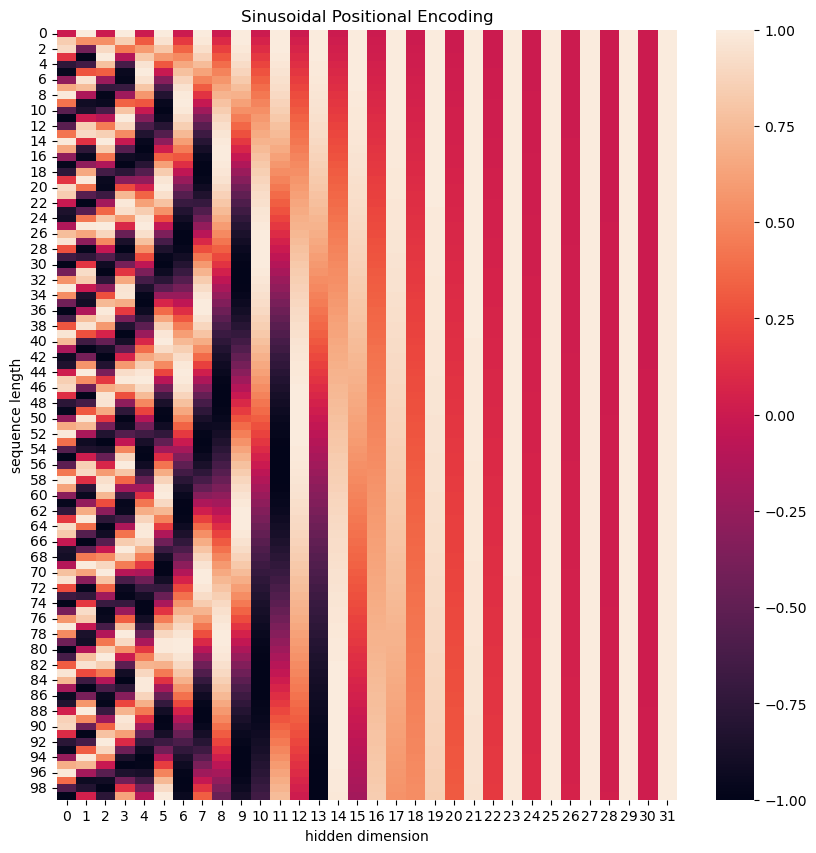

In [12]:
pe = PositionalEncoding(32, 0, 100).to(DEVICE)  # d_model, dropout-ratio, max_len
positional_encoding = pe.forward(Variable(torch.zeros(1, 100, 32, device=DEVICE))) # sequence lenHere are the position embedding visualisations, you can find the pattern changes with the increasing embedding dimensions.th, d_model

heatmap_data = positional_encoding.squeeze().detach().cpu().numpy()
plt.figure(figsize=(10,10))
sns.heatmap(heatmap_data)
plt.title("Sinusoidal Positional Encoding")
plt.xlabel("hidden dimension")
plt.ylabel("sequence length")

Text(0, 0.5, 'encoding value')

<Figure size 1500x500 with 0 Axes>

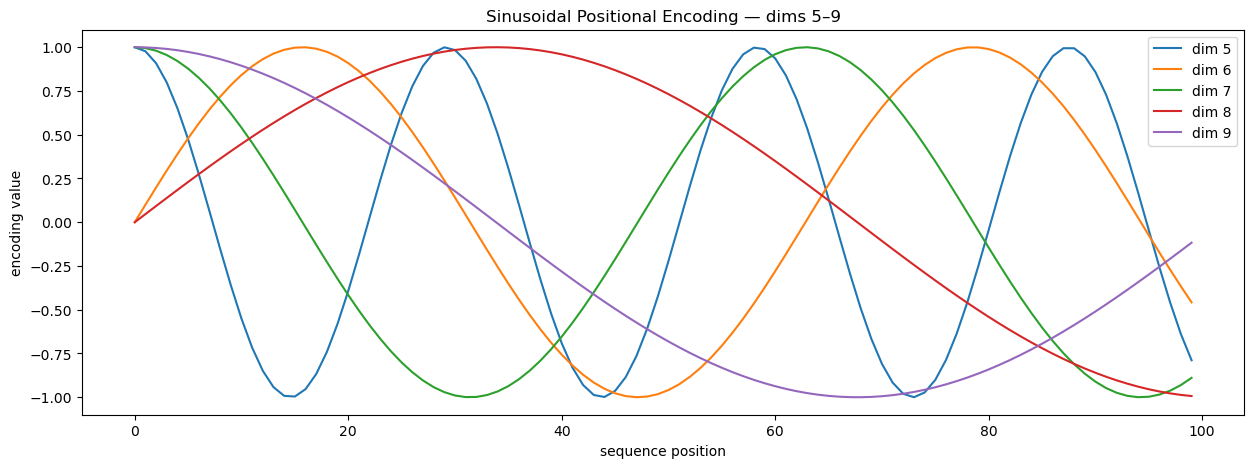

In [13]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(24, 0).to(DEVICE)
y = pe.forward(Variable(torch.zeros(1, 100, 24, device=DEVICE)))
y_np = y.squeeze().detach().cpu().numpy()
plt.figure(figsize=(15, 5))
for dim in [5,6,7,8,9]:
    plt.plot(np.arange(100), y_np[:, dim], label=f"dim {dim}")
plt.legend()
plt.title("Sinusoidal Positional Encoding — dims 5–9")
plt.xlabel("sequence position")
plt.ylabel("encoding value")

### Self Attention and Mask

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

We call our particular attention "**Scaled-Dot-Product Attention**". The input consists of queries and keys of dimension `dk`, and values of dimension `dv`.

We compute the dot products of the query with all keys, divide each by square root of `dk` , and apply a softmax function to obtain the weights on the values.

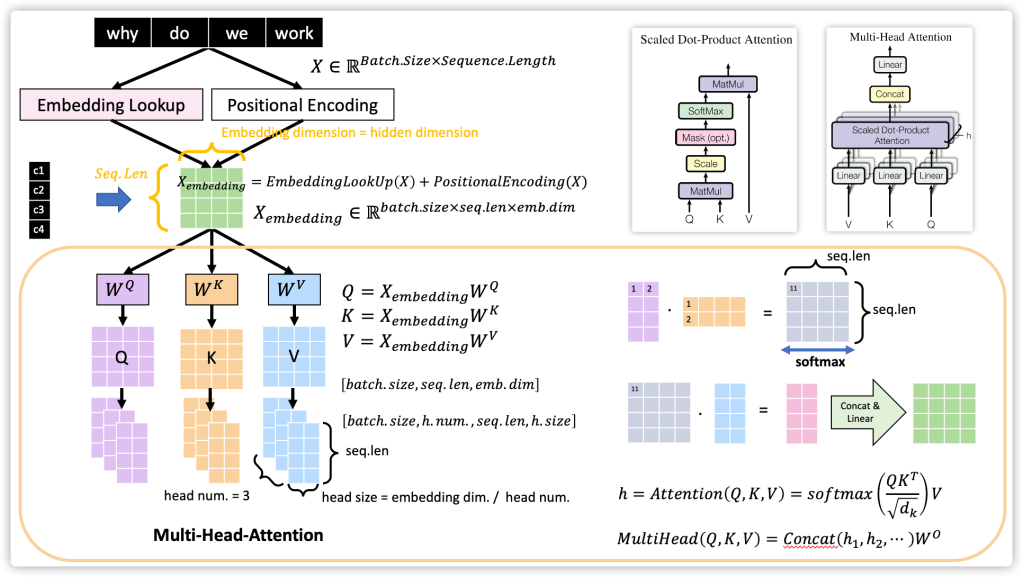

The two most commonly used attention functions are additive attention, and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor.

Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimised matrix multiplication code.

To illustrate why the dot products get large, assume that the components of `q` and `k` are independent random variables with mean 0 and variance 1 . Then their dot product, `𝑞⋅𝑘q⋅k` has mean 0 and variance `dk`, To counteract this effect, we scale the dot products by `1/sqrt(dk)`.

In [14]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1) 
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

In [15]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0 # check the h number
        self.d_k = d_model // h
        self.h = h
        # 4 linear layers: WQ WK WV and final linear mapping WO  
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0) # get batch size
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        # parttion into h sections，switch 2,3 axis for computation. 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) 
                             for l, x in zip(self.linears, (query, key, value))]
        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x) # final linear layer

### Attention Mask

The input  X is `[batch−size, sequence−length]`, we use 'padding' to fill the matrix with 0 with respect to the longest sequence. But this will case issues for the softmax computation. This means the padding sections join the computation, but they shouldn’t. So we create this mask to ignore these area by assign a large negative bias. Thus, the masked area will lead to 0 so we avoid them in computation. We use mini-batch data as input, means we feed multiply lines of sentences into the model for training and computation.

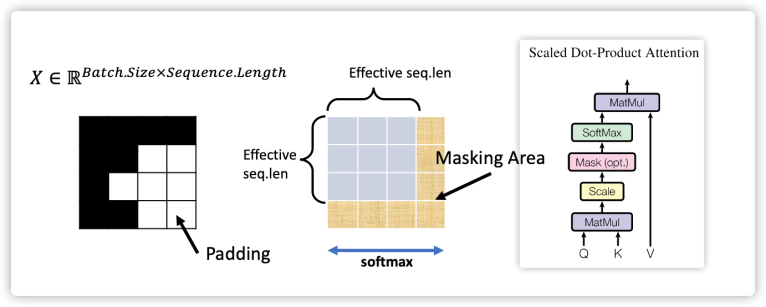

In Transformer, both encoder and decoder attention computations need masking operation, but their functions are different. In the decoder, the self-attention layer is only allowed to attend to earlier positions in the output sequence. This is done by masking future positions (setting them to ‘-inf’) before the softmax step in the self-attention calculation.

The “Encoder-Decoder Attention” layer works just like multiheaded self-attention, except it creates its Queries matrix from the layer below it, and takes the Keys and Values matrix from the output of the encoder stack.

Here, we define a batch object that holds the src (English) and target sentences (Chinese) for training, as well as constructing the masks.

In [16]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        # convert words id to long format.  
        src = torch.from_numpy(src).to(DEVICE).long()
        trg = torch.from_numpy(trg).to(DEVICE).long()
        self.src = src
        # get the padding postion binary mask
        # change the matrix shape to  1×seq.length
        self.src_mask = (src != pad).unsqueeze(-2)
        # if target is not empty, mask decoder target.
        if trg is not None:
            # decoder input from target 
            self.trg = trg[:, :-1]
            # decoder target from trg 
            self.trg_y = trg[:, 1:]
            # add attention mask to decoder input  
            self.trg_mask = self.make_std_mask(self.trg, pad)
            # check decoder output padding number
            self.ntokens = (self.trg_y != pad).data.sum()
     
    # Mask 
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask # subsequent_mask is defined in 'decoder' section.

### Layer Normalization and Residual Connection

1. LayerNorm: Layer Normalization normalize the hidden layer output into standard format, i.i.d, to boost the training efficency and model weight convergence (row wise).
2. Residual Connection: We employ a residual connection around each of the two sub-layers, followed by layer normalisation. We get the Value matrix with the weights from attentions  Attention(Q,K,V), and then we transpose it to make sure it shares the same shape of X embedding.

In [17]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
 
    def forward(self, x):
        mean = x.mean(-1, keepdim=True) # rows
        std = x.std(-1, keepdim=True)
        x_zscore = (x - mean)/ torch.sqrt(std ** 2 + self.eps) 
        return self.a_2*x_zscore+self.b_2 
 
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    SublayerConnection: connect Multi-Head Attention and Feed Forward Layers 
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
 
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

### Position-wise Feed-Forward Networks

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.

In [18]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
 
    def forward(self, x):
        h1 = self.w_1(x)
        h2 = self.dropout(h1)
        return self.w_2(h2)

### Transformer Encoder Overview

Now, we have programmed the four parts of the Transformer Encoder. Let us review how the data are transformed through all these layers.

1. Word Embedding and Positional Encoding.
2. Self-Attention and Mask.
3. Residual Connection and Layer Normalization.
4. Position-wise Feed-Forward Networks.
5. Repeat 3.

In [19]:
def clones(module, N):
    """
    "Produce N identical layers. N=6 in the original paper."
    Use deepcopy the weight are indenpendent.
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
 
class Encoder(nn.Module):
    "Core encoder is a stack of N layers (blocks)"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
 
    def forward(self, x, mask):
        """
        Pass the input (and mask) through each layer in turn.
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
 
# Each Encoder Block contains two sub-layers(Self-Attention,Position-wise) and 2 sublayer-connetions:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size # d_model
 
    def forward(self, x, mask):
        # X-embedding to Multi-head-Attention
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # X-embedding to feed-forwad nn
        return self.sublayer[1](x, self.feed_forward)

## 1.3 Decoder

After the introduction of the encoder structure, we can see the decoder shares a lot similarities of encoder.
It also stacks N times. But there is a Encoder-Deconder-Contex-Attention layer (sublayer[1]) between the Masked MHA[0] and FFN[2]. It use the output of the decoder as query to search the output of encoder with MHA, which makes decoder see all the outputs from encoder.

Decoding process:

- Input: Encoding output(memory) and i-1 position decoder output/
- Output: i position output work probabilities.
- decoding process works like RNN.

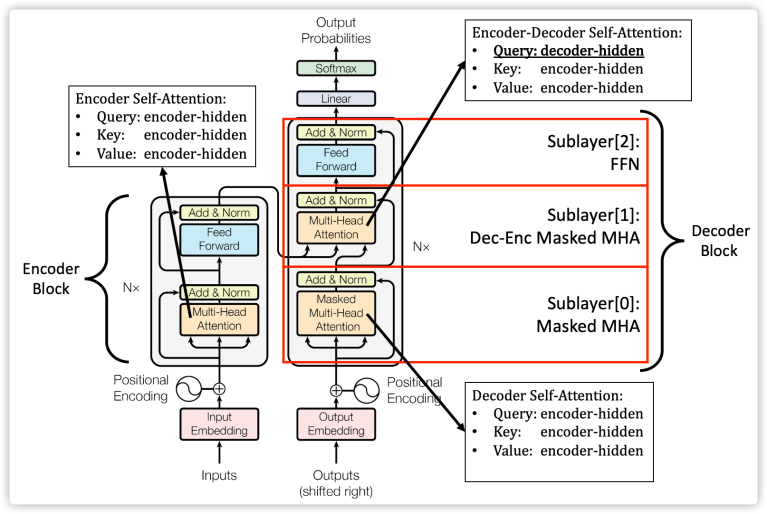

In [20]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        "Generic N layer decoder with masking."
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        Repeat decoder N times
        Decoderlayer get a input attention mask (src) 
        and a output attention mask (tgt) + subsequent mask 
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory # encoder output embedding
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        # Context-Attention：q=decoder hidden，k,v from encoder hidden
        return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking (subsequent_mask), combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i.

For Encoder src-mask, just mask the padding cells.
But for decoder trg-mask, we need mask the padding and add the subsequent-mask process.

In [21]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.”Yellow” color denote True.

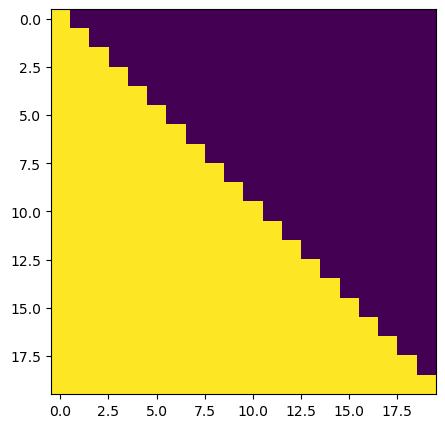

In [22]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

## 1.4 Transformer Model

Finally, let us put encoder and decoder together with the 'generator'.

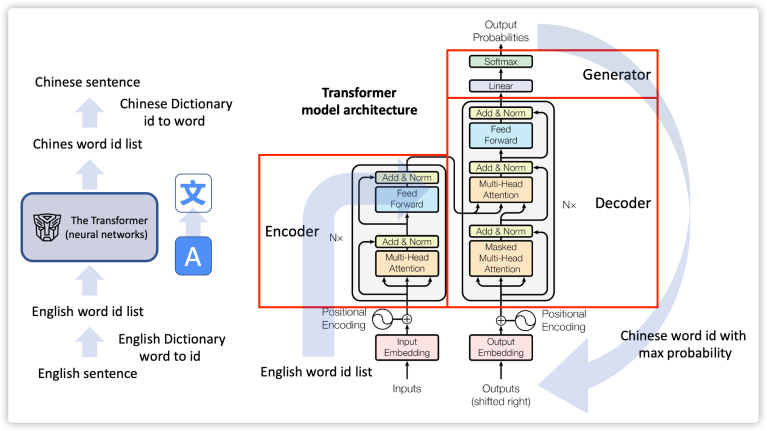

In [23]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
 
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
 
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
 
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        # encoder output will be the decoder's memory for decoding
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
 
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        # decode: d_model to vocab mapping
        self.proj = nn.Linear(d_model, vocab)
 
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

Set Parameters and Create the Full Transformer model Function.

In [24]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h = 8, dropout=0.1):
    c = copy.deepcopy
    # Attention 
    attn = MultiHeadedAttention(h, d_model).to(DEVICE)
    # FeedForward 
    ff = PositionwiseFeedForward(d_model, d_ff, dropout).to(DEVICE)
    # Positional Encoding
    position = PositionalEncoding(d_model, dropout).to(DEVICE)
    # Transformer 
    model = Transformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        nn.Sequential(Embeddings(d_model, src_vocab).to(DEVICE), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab).to(DEVICE), c(position)),
        Generator(d_model, tgt_vocab)).to(DEVICE)
     
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    # Paper title: Understanding the difficulty of training deep feedforward neural networks Xavier
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model.to(DEVICE)

## 1.5 Transformer Model Training: English-to-Mandarin

Regularization **Label Smoothing**: During training, we employed label smoothing of value. This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.

In [25]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
    
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

Here, 'size' is from vocabulary，'smoothing' is value to be distributed on non-ground-truth. We can see an example of how the mass is distributed to the words based on confidence.

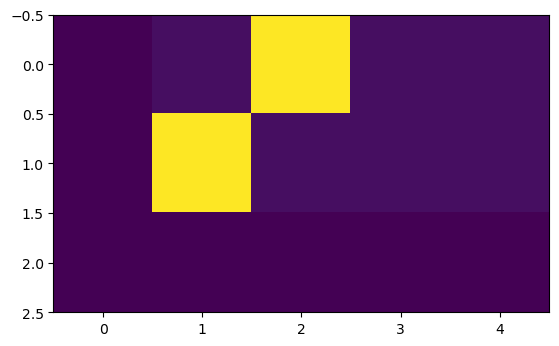

In [26]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.1)  #  ϵ=0.4
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), Variable(torch.LongTensor([2, 1, 0])))
# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)

Label smoothing actually starts to penalize the model if it gets very confident about a given choice.

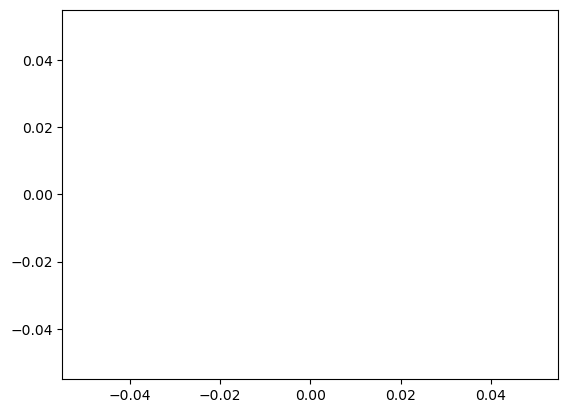

In [27]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).item()
 
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

### Loss Computation

In [28]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
    
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm.float()

### Optimizer with Warmup Learning Rate

According to the paper, they applied a warmup learning rate with Adam Optimizer which updates the learning rate over the course of training. This corresponds to increasing the learning rate linearly for the first “warmup_steps” training steps, and decreasing it thereafter proportionally to the inverse square root of the step number.

In [29]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
         
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
         
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
     
# We used factor=2, warmup-step = 4000
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

Example of the curves of this model for different model sizes and for optimization hyper-parameters.

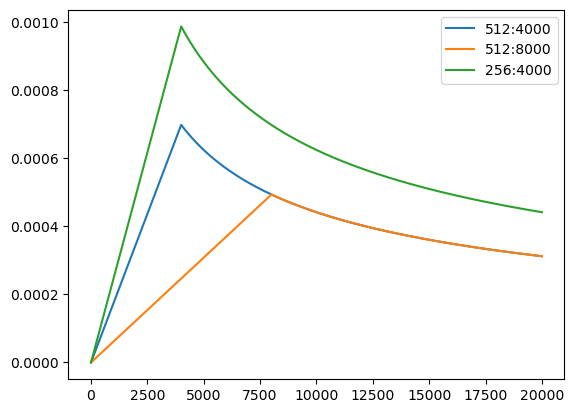

In [30]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

## 1.6 Training Loop

In [31]:
def run_epoch(data, model, loss_compute, epoch):
    start = time.time()
    total_tokens = 0.
    total_loss = 0.
    tokens = 0.
    for i , batch in enumerate(data):
        out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print(f"Epoch {epoch}/{EPOCHS} Batch: {i - 1} Loss: {loss / batch.ntokens} Tokens per Sec: {(tokens.float() / elapsed / 1000.)}s")
            start = time.time()
            tokens = 0
    return total_loss / total_tokens
 
def train(data, model, criterion, optimizer):
    """
    Train and Save the model.
    """
    # init loss as a large value
    best_dev_loss = 1e5
     
    for epoch in tqdm(range(EPOCHS)):
        # Train model 
        model.train()
        run_epoch(data.train_data, model, SimpleLossCompute(model.generator, criterion, optimizer), epoch)
        model.eval()
 
        # validate model on dev dataset
        print('>>>>> Evaluate')
        dev_loss = run_epoch(data.dev_data, model, SimpleLossCompute(model.generator, criterion, None), epoch)
        print('<<<<< Evaluate loss: {:.2f}'.format(dev_loss))
         
        # save the model with best-dev-loss (model validation)
        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            torch.save(model.state_dict(), SAVE_FILE) # SAVE_FILE = 'save/model.pt'
        print(f">>>>> current best loss: {best_dev_loss}")

In [32]:
# Step 1: Data Preprocessing
data = PrepareData(TRAIN_FILE, DEV_FILE)
src_vocab = len(data.en_word_dict)
tgt_vocab = len(data.cn_word_dict)
print(f"src_vocab {src_vocab}")
print(f"tgt_vocab {tgt_vocab}")
 
# Step 2: Init model
model = make_model(src_vocab, 
                   tgt_vocab, 
                   LAYERS, 
                   D_MODEL, 
                   D_FF,
                   H_NUM,
                   DROPOUT
                   )
 
# Step 3: Training model
print(">>>>> start train")
train_start = time.time()
criterion = LabelSmoothing(tgt_vocab, padding_idx = 0, smoothing= 0.0)
optimizer = NoamOpt(D_MODEL, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9,0.98), eps=1e-9))
 
train(data, model, criterion, optimizer)
print(f"<<<<<<< finished train, cost {time.time()-train_start:.4f} seconds")

src_vocab 5493
tgt_vocab 3194
>>>>> start train


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/50 Batch: 0 Loss: 8.096153259277344 Tokens per Sec: 1.4870291948318481s
Epoch 0/50 Batch: 50 Loss: 7.151193618774414 Tokens per Sec: 12.279725074768066s
Epoch 0/50 Batch: 100 Loss: 6.451451301574707 Tokens per Sec: 12.705857276916504s
Epoch 0/50 Batch: 150 Loss: 5.440917491912842 Tokens per Sec: 12.552963256835938s
Epoch 0/50 Batch: 200 Loss: 4.942413330078125 Tokens per Sec: 12.476381301879883s
>>>>> Evaluate
Epoch 0/50 Batch: 0 Loss: 5.17801570892334 Tokens per Sec: 15.722980499267578s
<<<<< Evaluate loss: 5.18
>>>>> current best loss: 5.1758623123168945
Epoch 1/50 Batch: 0 Loss: 4.722615718841553 Tokens per Sec: 5.801215171813965s
Epoch 1/50 Batch: 50 Loss: 4.95278263092041 Tokens per Sec: 12.518515586853027s
Epoch 1/50 Batch: 100 Loss: 4.796043872833252 Tokens per Sec: 12.840069770812988s
Epoch 1/50 Batch: 150 Loss: 4.366221904754639 Tokens per Sec: 12.555148124694824s
Epoch 1/50 Batch: 200 Loss: 4.023716926574707 Tokens per Sec: 12.47697925567627s
>>>>> Evaluate
Epoch 1/50

## 1.7 Prediction with our model!

In [33]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    Translate src with model
    """
    # decode the src 
    memory = model.encode(src, src_mask)
    # init 1×1 tensor as prediction，fill in ('BOS')id, type: (LongTensor)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    #  run the length of the sentence
    for i in range(max_len-1):
        # decode one by one
        out = model.decode(memory, 
                           src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        # Out to log_softmax 
        prob = model.generator(out[:, -1])
        # Get the max-prob id
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        # Concatenate with early predictions
        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys
 
def evaluate(data, model):
    """
    Make prediction with trained model, and print results.
    """
    with torch.no_grad():
        #  pick some random sentences from our data format.  
        #  here I used 10 sentences from data.dev-en.
        #  you can easily modify this function from new input.
        for i in np.random.randint(len(data.dev_en), size=10):
            # Print English sentence
            en_sent = " ".join([data.en_index_dict[w] for w in data.dev_en[i]]) # space between English words
            print("\n" + en_sent)
             
            # Print Target Chinese sentence
            cn_sent =  " ".join([data.cn_index_dict[w] for w in data.dev_cn[i]]) # no space in Chinese words
            print("".join(cn_sent))
             
            # convert English to tensor  
            src = torch.from_numpy(np.array(data.dev_en[i])).long().to(DEVICE)
            src = src.unsqueeze(0)
            # set attention mask
            src_mask = (src != 0).unsqueeze(-2)
            # apply model to decode, make prediction
            out = greedy_decode(model, src, src_mask, max_len=MAX_LENGTH, start_symbol=data.cn_word_dict["BOS"])
            # save all in the translation list 
            translation = []
            # convert id to Chinese, skip 'BOS' 0. 
            for j in range(1, out.size(1)):
                sym = data.cn_index_dict[out[0, j].item()]
                if sym != 'EOS':
                    translation.append(sym)
                else:
                    break
            print("translation: {}".format(" ".join(translation)))

In [34]:
def evaluate_bleu_from_ids(en_ids, cn_ids, data, model, label=""):
    references = []
    candidates = []
    smoothie = SmoothingFunction().method4

    with torch.no_grad():
        for i in range(len(en_ids)):
            src = torch.from_numpy(np.array(en_ids[i])).long().to(DEVICE).unsqueeze(0)
            src_mask = (src != 0).unsqueeze(-2)

            out = greedy_decode(model, src, src_mask, max_len=MAX_LENGTH, start_symbol=data.cn_word_dict["BOS"])

            pred = []
            for j in range(1, out.size(1)):
                sym = data.cn_index_dict[out[0, j].item()]
                if sym == 'EOS':
                    break
                pred.append(sym)

            ref = [data.cn_index_dict[idx] for idx in cn_ids[i] if data.cn_index_dict[idx] != 'EOS']
            candidates.append(pred)
            references.append([ref])

    bleu_score = corpus_bleu(references, candidates, smoothing_function=smoothie)
    print(f"{label} BLEU score: {bleu_score:.4f}")

In [ ]:
# Evaluation can take time it's suggested that you reduce to not using the full test.txt or val.txt

# Basic quantitative evaluation
#evaluate(data, model)

# Compute BLEU score example usage on test and validation
test_en, test_cn = data.load_data("data/test.txt")
test_en_ids, test_cn_ids = data.wordToID(test_en, test_cn, data.en_word_dict, data.cn_word_dict)
evaluate_bleu_from_ids(test_en_ids, test_cn_ids, data, model, label="Test")

dev_en_ids, dev_cn_ids = data.dev_en, data.dev_cn  # Already preprocessed during PrepareData
evaluate_bleu_from_ids(dev_en_ids, dev_cn_ids, data, model, label="Validation")

# Part 2: Evaluation and Exploration

The results of the explorations outlined below should be saved for for future discussion in part 3.

## 2.1 How good is it?

In part 1, we created a model and trained it to translate English to Mandarin. But how good is it really? Looking at the loss doesn't tell you how good it really is.

- If you are a native Mandarin speaker, how accurate is the translation? How native is the translation?
- If you don't speak Mandarin, try pasting the input and output into a LLM (e.g., [ChatGPT](https://chatgpt.com/), [Gemini](https://gemini.google.com/), [Deepseek](https://www.deepseek.com/), etc.) and asking it about the accuracy and nativeness of the translation. How well is the translation according to your LLM of choice?

> 💡 Tips: A tested prompt for ChatGPT 4o is: Given the input "i do n't have a lot of work , but it 's enough to keep me in the office this week", and the output "我 一 週 內 不 太 多 年 紀 ， 但 我 這 班 工 作 了 。" of a translation model. How accurate is the translation? How native is this translation? (Replace the sentences in the quotes with the input and output you want to test)

## 2.2 Hyperparameter Tuning and Analysis

In this section, we want you to explore how changing key Transformer hyperparameters can affect model performance and internal behavior. We suggest modifying some of the parameters outlined below:

- Layers: number of encoder and decoder layers
- H_num: number of attention heads
- d_ff: dimensionality of the inner feed-forward layer
- d_model: dimensionality of the vector representing each token

Note, we suggest adjusting at least two parameters in some manner, ensure to save the output results and observations.

## 2.3 Visualizing the Multiheaded-Attention

In this section, we will visualize the multi-head attention module to see how each token is effecting the computation of other tokens. After running the cells below, you will see two heat maps. But what are they?

Explaination:

Encoder Heat-map:
- Every token in the source sentence contributes to every other token (including itself) in that sentence.
- Query Position: Which token we are computing a new representation for.
- Key Position: Which token in the source it is weighting when building that representation.
- If you see a strong bright spot at, for example, row 3 col 7, it means that when computing the new representation for token 3, it is relying heavily on token 7.

Decoder Heat-map:
- Each token in the target sentence (the output) attends to the encoder's output (the source). The decoder uses this method to predict the next word according to the source context.
- Target Token Index: The index of the target tokens (Chinese character list)
- Source Token: Do I have to explain this?
- If you see a strong bright spot at, for example, row 3 col 7, it means that when generating the 3rd Chinese character, it referenced heavily on the 7th English word.

> ⚠️ The range of debug and full mode are different, hence, you might run into index out of bounds during debug mode. Just read the error message and play around.

In [ ]:
# Tweak these to see different graphs:
example_idx = 10          # which sentence in data.dev_en to visualize
enc_layer_idx = 0         # encoder layer index
dec_layer_idx = 0         # decoder layer index
head_idx = 0              # which attention head to plot

In [ ]:
# Don't modify this unless you know what you are doing
# Print the example sentences
# English (source)
src_ids = data.dev_en[example_idx]
src_tokens = [data.en_index_dict[i] for i in src_ids]
print("Source English:", " ".join(src_tokens))
# Chinese (reference)
# strip BOS/EOS = first/last token
ref_ids = data.dev_cn[example_idx][1:-1]
ref_tokens = [data.cn_index_dict[i] for i in ref_ids]
print("Target Chinese:", "".join(ref_tokens))
tgt_ids = data.dev_cn[example_idx][:-1]
print("Target Chinese Index:", "".join(str(i)+" " for i in tgt_ids))

# Forward pass one time to populate .attn in each MultiHeadedAttention
# Prep
src_seq = torch.from_numpy(np.array(data.dev_en[example_idx])).unsqueeze(0).long().to(DEVICE)
src_mask = (src_seq != PAD).unsqueeze(-2)
bos_id = data.cn_word_dict["BOS"]
tgt_seq = torch.LongTensor([tgt_ids]).to(DEVICE)  
tgt_mask = subsequent_mask(tgt_seq.size(1)).type_as(src_mask.data)

# Run forward pass once
model.eval()
with torch.no_grad():
    _ = model(src_seq, tgt_seq, src_mask, tgt_mask)

# Extract datas
# Encoder self-attention: shape [batch, heads, src_len, src_len]
enc_attn = model.encoder.layers[enc_layer_idx].self_attn.attn[0, head_idx].cpu().numpy()

# Decoder cross-attention: shape [batch, heads, tgt_len, src_len]
dec_cross_attn = model.decoder.layers[dec_layer_idx].src_attn.attn[0, head_idx].cpu().numpy()

# Plot encoder self-attention
plt.figure(figsize=(6,6))
sns.heatmap(enc_attn, cmap='viridis')
plt.title(f"Encoder Layer {enc_layer_idx} – Head {head_idx}")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.show()

# Plot decoder cross-attention
dec_cross_attn = model.decoder.layers[dec_layer_idx].src_attn.attn[0, head_idx].cpu().numpy()

plt.figure(figsize=(6, 4))
sns.heatmap(dec_cross_attn, cmap='viridis', 
            xticklabels=[data.en_index_dict[i] for i in data.dev_en[example_idx]],
            yticklabels=[i for i in tgt_ids])
plt.xlabel('Source Tokens')
plt.ylabel('Target Token Index')
plt.title(f'Decoder Cross-Attention (Layer {dec_layer_idx}, Head {head_idx})')
plt.show()

## 2.4 Ablation Study: Removing Attention and Positional Encoding

In the original Transformer paper "Attention Is All You Need", the attention mechanism is one of the main concepts that carried over from the LSTM architecture to the Transformer architecture. But attention itself does not account for position and therefore positional encoding also became critical in ensuring positional information of the input is accounted for, without it the model will struggle to distinguish the order of input tokens.

Try exploring different variations of including or excluding attention and positional encoding, and see how the model responds.
- Replace attention layers with no-op layers (no operation)
- Replace positional encoding module with a no-op module

Below is a provided "NoAttention" and "NoPositionalEncoding" class to assist in applying the no-op behavior.

In [ ]:
class NoAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(NoAttention, self).__init__()
        self.d_model = d_model

    def forward(self, query, key, value, mask=None):
        # Return the input unchanged
        return query
        
class NoPositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()

    def forward(self, x):
        return x # Returns x unchanged

# Part 3: Test your Knowledge

#### Q1: Discuss the conceptual questions below in a short answer response:

A) What are the main differences between Transformers and LSTMs models, and why and how did Transformers overtake LSTMs in popularity?

B) Compare and contrast the roles of the encoder and decoder in a Transformer model, also discuss how data flows through and between them.

C) Why is positional encoding needed in Transformers? Explain how it is used in this model's architecture.

D) Why is attention neeeded in Transformer? Explain how it is used in this model's architecture.

TODO

#### Q2: Answer whether the following statements are True or False, and provide a brief explanation for each statement:

A) Transformers require recurrence to capture long-term dependencies.

B) Self-attention allows each token to directly consider all others at once.

C) Increasing the number of attention heads always improves performance.

D) Masked attention is used in the encoder to prevent cheating.

TODO

#### Q3: In the beginning of part 2, you were asked about the performance of the accuracy and nativeness of the translation. Report your answers here.

TODO

#### Q4: In part 2.2, you explored adjusting different hyperparameters. Explain what parameters you changed and the effect that you saw from each change. These results can be quantitative, qualitative, or even both, then explain why you think these changes occurred based on your understanding of the model.

TODO

#### Q5: In part 2.3, you were asked to explain the functionality of the multiheaded-attention component in this model and support your claim by using the figures generated in the section. Insert your answers here. Your answer should be no less than 75 words.

TODO

#### Q6: In part 2.4, you experimented with removing or disabling key components of the Transformer model, including attention, positional encoding, or both. What effects did you observe on the model's behavior, translation quality, or performance? Provide a short comparison or discussion on how these key components impact the performance.

TODO

# References

- Transformer Explainer [https://poloclub.github.io/transformer-explainer/](https://poloclub.github.io/transformer-explainer/)

- A. Vaswani et al., *Attention Is All You Need*, 2023. [Online]. Available: https://arxiv.org/abs/1706.03762

- Chris Cui, *Annotated Transformer: English-to-Chinese Translator*, 2020.  
GitHub: https://github.com/cuicaihao/Annotated-Transformer-English-to-Chinese-Translator 
Blog: https://cuicaihao.com/the-annotated-transformer-english-to-chinese-translator/  
Licensed under the MIT License.

- Ketan Doshi, *Foundations of NLP Explained – BLEU Score and WER Metrics*, Towards Data Science, May 2021.  
Available: https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b

# Appendix

MIT License for the original English-to-Mandarin Transformer by Chris Cui:

Copyright (c) 2020 Chris Cui

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.